In [2]:
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
import re
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Load a pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.to(device)  # Move the model to the GPU if available

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [5]:
# Check if GPU is available, and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Wrap the model in the DataParallel wrapper
model = torch.nn.DataParallel(model)

In [7]:
# Function to remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text_without_punct = text.translate(translator)
    return re.sub(r'\s+', ' ', text_without_punct).strip()  # Replace consecutive spaces with a single space


# Function to lowercase text
def lowercase_text(text):
    return text.lower()

# Function to lemmatize text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    lemmatized_words = []
    for word in word_tokenize(text):
        if word not in stop_words:
            lemmatized_words.append(lemmatizer.lemmatize(word))
        else:
            lemmatized_words.append(word)  # Keep stopwords unchanged
    return ' '.join(lemmatized_words)

# Function to remove stop words
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Function to preprocess text
def preprocess_text(text):
    # Add more preprocessing steps as needed
    text = remove_punctuation(text)
    text = lowercase_text(text)
    text = remove_stop_words(text)
    text = lemmatize_text(text)
    return text

# Function to get BERT embeddings
def get_bert_embeddings(text):
    # This function should be defined with the appropriate model and tokenizer setup.
    # Make sure to define and load the model and tokenizer before calling this function.
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.cpu().numpy()

In [8]:
# Function to apply K-means clustering
def apply_kmeans(embeddings, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(embeddings)
    return kmeans.labels_


In [9]:
# Define a function to display BERT embeddings and preprocessed text
def display_bert_embedding_and_preprocessing(data, row_idx):
    # Get BERT embeddings for the specified row
    embedding = data.iloc[row_idx, -768:]  # Assuming the embeddings have 768 dimensions
    preprocessed_text = data.iloc[row_idx]['Text']

    # Display BERT embeddings
    print("BERT Embeddings:")
    print(embedding)
    
    # Display preprocessed text
    print("\nPreprocessed Text:")
    print(preprocessed_text)
    
def preprocess_and_get_embeddings(row):
    text = row.get('Text', '')  # Use get() to handle missing values
    embeddings = get_bert_embeddings(text)
    return embeddings

In [10]:
# Read the CSV file
data = pd.read_csv('cluster_Data.csv', encoding='latin-1')

# Print the list of column names
print(data.columns)

Index(['Title', 'Abstract', 'Text', 'Text_Embeddings', 'Text_Cluster'], dtype='object')


In [11]:
# Merge the 'Title' and 'Abstract' columns into a single column called 'Text'
data['Text'] = data['Title']+ ',' + data['Abstract']

In [12]:
# Assuming 'data' is your DataFrame
data['Text'] = data['Text'].apply(preprocess_text)

AttributeError: 'float' object has no attribute 'translate'

In [13]:
# Process and obtain embeddings for each row
embeddings = data.apply(preprocess_and_get_embeddings, axis=1)
embeddings = np.vstack(embeddings.to_numpy())  # Convert to a NumPy array

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [56]:
from sklearn.cluster import KMeans

In [57]:
# Apply K-means clustering
num_clusters = 3  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(embeddings)


In [58]:
# Check the shape of embeddings
print(embeddings.shape)  # Should be (number_of_samples, embedding_dimension)
print("\n")

(326, 768)




In [61]:
# Choose a row to display (change row_idx to the desired row)
row_idx = 1  # Change this to the index of the row you want to display
display_bert_embedding_and_preprocessing(data, row_idx)

BERT Embeddings:
2               0.223096
3               0.070163
4               0.269189
5               0.038793
6              -0.189793
                  ...   
765            -0.491111
766             0.154358
767             0.162868
ClusterLabel           4
Cluster                0
Name: 1, Length: 768, dtype: object

Preprocessed Text:
case study poultry egg production businessa case study poultry egg production business studied help egg producer business process especially financial aspect feature study blueprint decision support system include technical financial management socio economic aspect data context diagram blueprint system iterative life cycle model used methodology consists data gathering data analysis design market survey total based analysis result data gathered setting poultry egg production business design decision support system positive current manual system industry must upgraded meet demand growing business market


In [62]:
# Tokenize the text in your dataset
stop_words = set(stopwords.words('english'))
data['Tokens'] = data['Text'].apply(lambda x: [token for token in tokenizer.tokenize(x) if token not in stop_words])


In [63]:
# Create a list of words based on your tokens
word_list = [word for tokens in data['Tokens'] for word in tokens]


In [49]:
# Concatenate the embeddings and cluster labels with the original DataFrame
data = pd.concat([data, pd.DataFrame(embeddings), pd.Series(kmeans_labels, name='ClusterLabel')], axis=1)

In [50]:
# Check the shape of embeddings and cluster labels
print(embeddings.shape)  # Should be (number_of_samples, embedding_dimension)
print("Cluster Labels:", data['ClusterLabel'].unique())

(326, 768)
Cluster Labels: [2 4 1 0 3]


In [51]:
# Choose a row to display (change row_idx to the desired row)
row_idx = 200  # Change this to the index of the row you want to display
display_bert_embedding_and_preprocessing(data, row_idx)

BERT Embeddings:
1               0.235173
2               0.290928
3               0.064327
4               0.105875
5               0.182038
                  ...   
764            -0.435931
765            -0.227162
766             0.120141
767             0.546278
ClusterLabel           2
Name: 200, Length: 768, dtype: object

Preprocessed Text:
medical supply inventory distribution system pnp hospitalthe pharmacy pnp regional xiii health service hospital us traditional way inventory medical supply equipment performing daily transaction paper pen used recording supply thus result poor inventory management product availability monitoring deemed necessary response pnp working environment medical supply inventory system pnp hospital designed help pnp hospital improve staff work efficiency computerizing part business process automation inventory monitoring medicine product done properly cope high demand pnp keywords information system inventory inventory system laravel postgresql


In [52]:
# Check the shape of text_embeddings
#text_embeddings = embeddings  # Assign the embeddings to text_embeddings
print(embeddings.shape)  # Should be (number_of_samples, embedding_dimension)
print("\n")
# Choose a row to display (change row_idx to the desired row)
row_idx = 200 # Change this to the index of the row you want to display
display_bert_embedding_and_preprocessing(data, row_idx)

# Tokenize the text in your dataset
stop_words = set(stopwords.words('english'))

(326, 768)


BERT Embeddings:
1               0.235173
2               0.290928
3               0.064327
4               0.105875
5               0.182038
                  ...   
764            -0.435931
765            -0.227162
766             0.120141
767             0.546278
ClusterLabel           2
Name: 200, Length: 768, dtype: object

Preprocessed Text:
medical supply inventory distribution system pnp hospitalthe pharmacy pnp regional xiii health service hospital us traditional way inventory medical supply equipment performing daily transaction paper pen used recording supply thus result poor inventory management product availability monitoring deemed necessary response pnp working environment medical supply inventory system pnp hospital designed help pnp hospital improve staff work efficiency computerizing part business process automation inventory monitoring medicine product done properly cope high demand pnp keywords information system inventory inventory system laravel postg

In [42]:
data['Tokens'] = data['Text'].apply(lambda x: [token for token in tokenizer.tokenize(x) if token not in stop_words])

# Create a list of words based on your tokens
word_list = [word for tokens in data['Tokens'] for word in tokens]

# Perform hierarchical clustering using DIANA
linkage_matrix = linkage(embeddings, method='ward', metric='euclidean')

In [43]:
from sklearn.cluster import KMeans

In [53]:
# Choose the number of clusters (you can adjust this parameter)
num_clusters = 5

# Extract BERT embeddings from the DataFrame
bert_embeddings = data.iloc[:, -768:].to_numpy()

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(bert_embeddings)

# Display the distribution of samples in each cluster
print("Cluster distribution:")
print(data['Cluster'].value_counts())

Cluster distribution:
Cluster
3    106
1     85
2     55
0     52
4     28
Name: count, dtype: int64


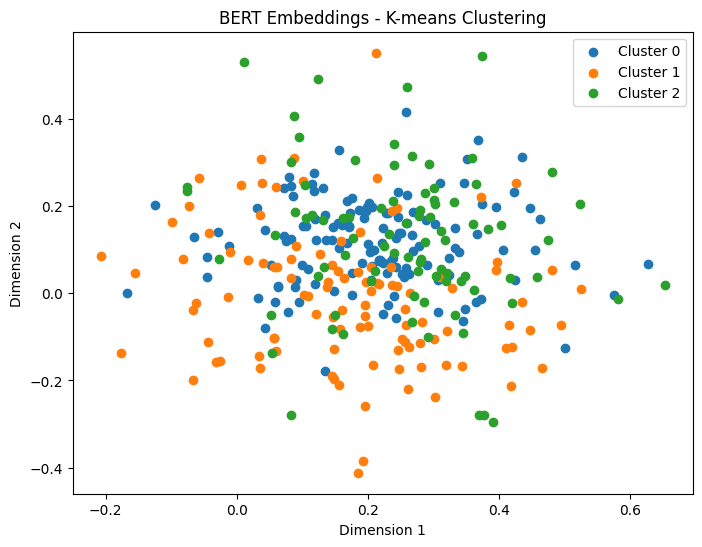

BERT Embeddings:
2               0.290928
3               0.064327
4               0.105875
5               0.182038
6               0.061457
                  ...   
765            -0.227162
766             0.120141
767             0.546278
ClusterLabel           2
Cluster                0
Name: 200, Length: 768, dtype: object

Preprocessed Text:
medical supply inventory distribution system pnp hospitalthe pharmacy pnp regional xiii health service hospital us traditional way inventory medical supply equipment performing daily transaction paper pen used recording supply thus result poor inventory management product availability monitoring deemed necessary response pnp working environment medical supply inventory system pnp hospital designed help pnp hospital improve staff work efficiency computerizing part business process automation inventory monitoring medicine product done properly cope high demand pnp keywords information system inventory inventory system laravel postgresql


In [65]:
# Scatter plot
plt.figure(figsize=(8, 6))

for cluster_label in range(num_clusters):
    cluster_data = data[data['Cluster'] == cluster_label]
    plt.scatter(cluster_data.iloc[:, -768], cluster_data.iloc[:, -767], label=f'Cluster {cluster_label}')

plt.title('BERT Embeddings - K-means Clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

# Choose a row to display (change row_idx to the desired row)
row_idx = 200  # Change this to the index of the row you want to display
display_bert_embedding_and_preprocessing(data, row_idx)

# Tokenize the text in your dataset
stop_words = set(stopwords.words('english'))
data['Tokens'] = data['Text'].apply(lambda x: [token for token in tokenizer.tokenize(x) if token not in stop_words])

# Create a list of words based on your tokens
word_list = [word for tokens in data['Tokens'] for word in tokens]